In [1]:
import nltk as nltk
nltk.download('stopwords')
nltk.download('wordnet')
!pip install -U gensim
!pip install -U wordcloud
!pip install -U python-Levenshtein

[nltk_data] Downloading package stopwords to C:\Users\Edit
[nltk_data]     6\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Edit
[nltk_data]     6\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


  Running setup.py clean for python-Levenshtein
Failed to build python-Levenshtein
    Running setup.py install for python-Levenshtein: started
    Running setup.py install for python-Levenshtein: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Edit 6\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Edit 6\\AppData\\Local\\Temp\\pip-install-ub5d2lql\\python-levenshtein\\setup.py'"'"'; __file__='"'"'C:\\Users\\Edit 6\\AppData\\Local\\Temp\\pip-install-ub5d2lql\\python-levenshtein\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Edit 6\AppData\Local\Temp\pip-wheel-6owkdec4'
       cwd: C:\Users\Edit 6\AppData\Local\Temp\pip-install-ub5d2lql\python-levenshtein\
  Complete output (27 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\Levenshtein
  copying Levenshtein\StringMatcher.py -> build\lib.win-amd64-3.8\Levenshtein
  copying Levenshtein\__init__.py -> build\lib.

## Reading and formatting training dataset 

In [2]:
import pandas as pd
import nltk as nltk

#Reading dataset
pd.set_option("max_colwidth", 200)
data = pd.read_csv("fake_or_real_news.csv")

#Removing unused column
data = data.drop(labels = "Unnamed: 0", axis = 1)

#Labelling remaining columns
data.columns=["title", "body_text", "label"]

#Uncomment the below lines if PC is struggling to process the dataset. The value for the frac parameter represents
#the amount of data to drop from the dataset e.g. .5 = 50%.
#data = data.drop(data.query('label == "FAKE"').sample(frac=.5).index)
#data = data.drop(data.query('label == "REAL"').sample(frac=.5).index)

data.head()

,title,body_text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to wa...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will ne...,FAKE
2,Kerry to go to Paris in gesture of sympathy,"U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerr...",REAL
3,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People F...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners Hillary Clinton and Donald Trump are leading in the polls.\n\nTrump is now vowing to win enough delegates to clinch the Republican nomination and pre...,REAL


## Initial dataset analysis

In [3]:
# The size of that data set in (row count, column count) format

print(data.shape)

# The amount of data labeled as real and fake
print(data['label'].value_counts())

# The amount of missing data in the label, title, and body_text columns

print('Number of missing values in label: {}'.format(data['label'].isnull().sum()))
print('Number of missing values in title: {}'.format(data['title'].isnull().sum()))
print('Number of missing values in body_text: {}'.format(data['body_text'].isnull().sum()))

(6335, 3)
REAL    3171
FAKE    3164
Name: label, dtype: int64
Number of missing values in label: 0
Number of missing values in title: 0
Number of missing values in body_text: 0


## Creating a preprocessing function which removes punctuations, tokenizes text, removes stop words, and lemmatizes text

In [4]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()
ps = nltk.PorterStemmer()

def remove_punctuation(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return text 

def tokenize(text):
    text = re.split('\W+', text)
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    return text

def lemmatize(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

def pre_process_data(text):
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stop_words(text)
    text = lemmatize(text)
    return text

## Creating word cloud for top 100 occuring words in training dataset

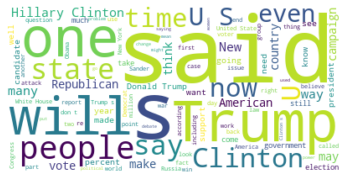

In [5]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

text = " ".join(articles for articles in data.body_text)
wordcloud = WordCloud(background_color="white", max_words=100).generate(text)

# Display the generated image:

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save wordcloud
wordcloud.to_file("datasetWordCloud.png")

## Vectorizing training data using CountVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer=pre_process_data)
x_count = count_vectorizer.fit_transform(data['body_text'])

#Transforming sparce matrix into dataframe - model requires input as dataframe
x_count_features = pd.DataFrame(x_count.toarray()) 

## Vectorizing training data using TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=pre_process_data)
x_tfidf = tfidf_vectorizer.fit_transform(data['body_text'])

#Transforming sparce matrix into dataframe - model requires input as dataframe
x_tfidf_features = pd.DataFrame(x_tfidf.toarray()) 

## Vectorizing training data using Word2Vec

In [8]:
import gensim
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

#Preprocessing training dataset to remove stop words etc.

data['pre_proccessed_text'] = data['body_text'].apply(lambda x: pre_process_data(x))

#Training Word2Vec model on words in the pre processed data that occur more than once

embeddings = Word2Vec(data['pre_proccessed_text'], vector_size=100, window=5, min_count=2, workers=4)

# Reprenting each word in each article with a word2Vec embedding if that word has been learning by the word2vec model 
# (occurs more than once)
# The result is an array of arrays, where each inner array stores the embeddings of words for a given article. Any words not
# learnt by the model are excluded.

w2v_vect = np.array([np.array([embeddings.wv[word] for word in article if word in embeddings.wv.index_to_key])
                     for article in data['pre_proccessed_text']])
      
# Averages the embeddings of words in an article
# The result is an array which stores 100-dimensional vectors for each article in the corpus

w2v_vect_avg = []
for vect in w2v_vect:
    w2v_vect_avg.append(vect.mean(axis=0))
    
# Vectors are stored in a pandas dataframe so that they can be interpreted by the model

x_word2Vec_features = pd.DataFrame(w2v_vect_avg)                                 

C:\Users\Edit 6\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
<ipython-input-8-a789e568c0f5>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  w2v_vect = np.array([np.array([embeddings.wv[word] for word in article if word in embeddings.wv.index_to_key])


## Create evaluation metrics

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, precision_score, make_scorer
from functools import partial
import time

scoring = {'Accuracy': 'accuracy', 
           'Precision': make_scorer(precision_score, pos_label = 'FAKE'),
           'Recall' : make_scorer(recall_score, pos_label = 'FAKE')}

graph_accuracy_data = []
graph_precision_data = []
graph_recall_data = []
graph_x_names = []

def process_results(model_name, model_score):
    model_accuracy = (model_score.get("test_Accuracy").mean()) * 100
    model_precision = (model_score.get("test_Precision").mean()) * 100
    model_recall = (model_score.get("test_Recall").mean()) * 100
    graph_accuracy_data.append(model_accuracy)
    graph_precision_data.append(model_precision)
    graph_recall_data.append(model_recall)
    graph_x_names.append(model_name)
    print(model_name)
    print('Accuracy is {}'.format(model_accuracy))
    print('Precision is {}'.format(model_precision))
    print('Recall is {}'.format(model_recall))
    print("--- %s seconds ---\n" % (time.time() - start_time))
    

## Training and evaluating models on CountVectorizer features

In [10]:
print('Models trained on CountVectorizer features')

# Logistic Regression classifier

start_time = time.time()
lr = LogisticRegression()
lr_score = cross_validate(lr, x_count_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('LR', lr_score)

# Random Forest classifier

start_time = time.time()
rf = RandomForestClassifier(n_jobs=-1)
rf_score = cross_validate(rf, x_count_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('RF', rf_score)

# Gaussian Naive Bayes classifier

start_time = time.time()
gnb = GaussianNB()
gnb_score = cross_validate(gnb, x_count_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('GNB', gnb_score)

# Linear Support Vector Machine

start_time = time.time()
linear_svc = svm.SVC(kernel='linear')
linear_svc_score = cross_validate(linear_svc, x_count_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('Linear SVM', linear_svc_score)

# Support Vector Machine with Polynomial kernel

start_time = time.time()
poly_svc = svm.SVC(kernel='poly')
poly_svc_score = cross_validate(poly_svc, x_count_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('Poly SVM', poly_svc_score)

# Support Vector Machine with Radial Basis Fuction kernel

start_time = time.time()
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc_score = cross_validate(rbf_svc, x_count_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('RBF SVM', rbf_svc_score)

Models trained on CountVectorizer features
LR
Accuracy is 93.03867403314918
Precision is 92.94260538134318
Recall is 93.14136020957065
--- 195.30200123786926 seconds ---

RF
Accuracy is 91.00236779794791
Precision is 91.89053269717785
Recall is 89.94945707600935
--- 93.06443643569946 seconds ---

GNB
Accuracy is 81.5153906866614
Precision is 88.26495220450695
Recall is 72.6606275121483
--- 27.790130138397217 seconds ---

Linear SVM
Accuracy is 90.51302288871351
Precision is 90.62976995489058
Recall is 90.36004959305698
--- 1317.6071696281433 seconds ---

Poly SVM
Accuracy is 68.68192580899763
Precision is 62.07865615478087
Recall is 95.85992960985462
--- 3938.56223654747 seconds ---

RBF SVM
Accuracy is 88.03472770323599
Precision is 83.2952053409173
Recall is 95.16437698722179
--- 2714.384279727936 seconds ---



## Graphical representation of model permance when trained on CountVectorizer features

Text(0.5, 1.0, 'CountVectorizer - Recall')

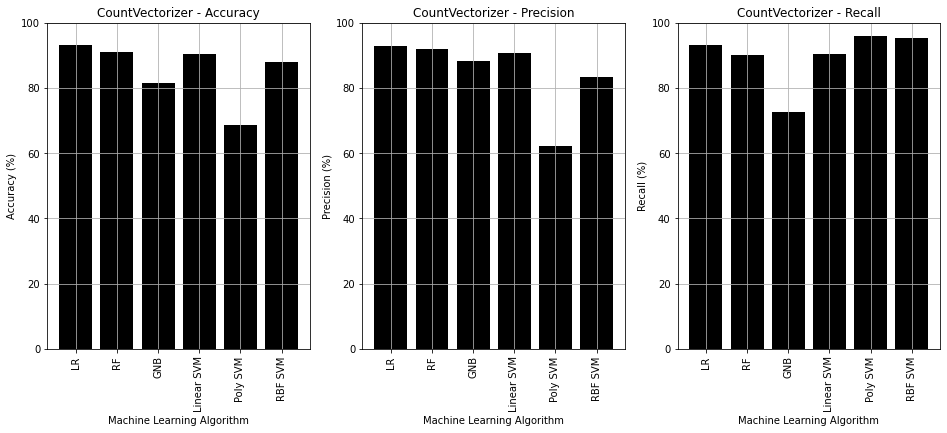

In [11]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

#plot 1:

plt.subplot(1, 3, 1)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_accuracy_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Accuracy (%)')
plt.title('CountVectorizer - Accuracy')

#plot 2:

plt.subplot(1, 3, 2)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_precision_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Precision (%)')
plt.title('CountVectorizer - Precision')

#plot 3:

plt.subplot(1, 3, 3)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_recall_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Recall (%)')
plt.title('CountVectorizer - Recall')


In [12]:
# Resetting graph data

graph_accuracy_data = []
graph_precision_data = []
graph_recall_data = []
graph_x_names = []

## Training and evaluating models on TF-IDF features

In [13]:
print('Models trained on TF-IDF features')

#Logistic Regression classifier

start_time = time.time()
lr = LogisticRegression()
lr_score = cross_validate(lr, x_tfidf_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('LR', lr_score)

#Random Forest classifier

start_time = time.time()
rf = RandomForestClassifier(n_jobs=-1)
rf_score = cross_validate(rf, x_tfidf_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('RF', rf_score)

#Gaussian Naive Bayes classifier

start_time = time.time()
gnb = GaussianNB()
gnb_score = cross_validate(gnb, x_tfidf_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('GNB', gnb_score)

#Linear Support Vector Machine

start_time = time.time()
linear_svc = svm.SVC(kernel='linear')
linear_svc_score = cross_validate(linear_svc, x_tfidf_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('Linear SVM', linear_svc_score)

#Support Vector Machine with Polynomial kernel

start_time = time.time()
poly_svc = svm.SVC(kernel='poly')
poly_svc_score = cross_validate(poly_svc, x_tfidf_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('Poly SVM', poly_svc_score)

#Support Vector Machine with Radial Basis Fuction kernel

start_time = time.time()
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc_score = cross_validate(rbf_svc, x_tfidf_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('RBF SVM', rbf_svc_score)

Models trained on TF-IDF features
LR
Accuracy is 92.05998421468034
Precision is 89.63221663780739
Recall is 95.13253144559762
--- 80.48676657676697 seconds ---

RF
Accuracy is 91.55485398579322
Precision is 90.74777926374978
Recall is 92.54099426080347
--- 111.86769485473633 seconds ---

GNB
Accuracy is 81.31018153117601
Precision is 85.85267418118188
Recall is 74.9364588957546
--- 28.054651737213135 seconds ---

Linear SVM
Accuracy is 94.39621152328336
Precision is 93.29409182506406
Recall is 95.66995620613115
--- 1998.6136898994446 seconds ---

Poly SVM
Accuracy is 86.20363062352013
Precision is 79.60645542443014
Recall is 97.31347611334414
--- 3955.455296754837 seconds ---

RBF SVM
Accuracy is 93.43330702446725
Precision is 91.05689406559378
Recall is 96.33351330813686
--- 3472.6491556167603 seconds ---



## Graphical representation of model permance when trained on TF-IDF features

Text(0.5, 1.0, 'TF-IDF - Recall')

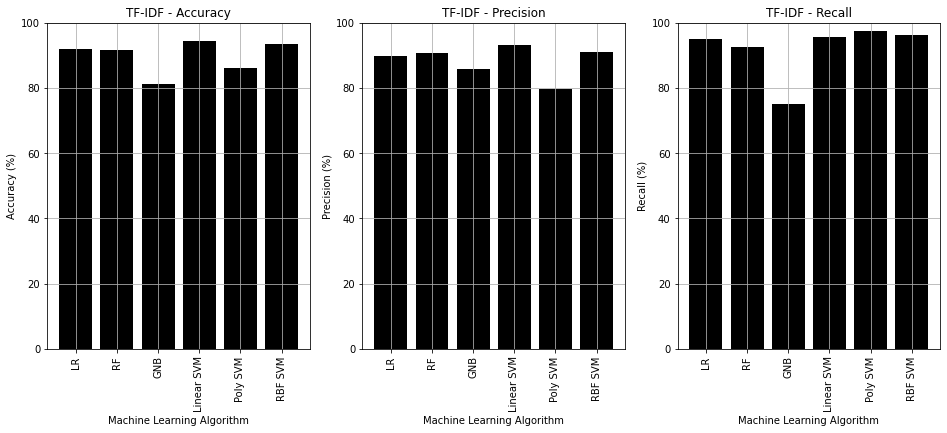

In [14]:
plt.figure(figsize=(16, 6))

#plot 1:

plt.subplot(1, 3, 1)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_accuracy_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Accuracy (%)')
plt.title('TF-IDF - Accuracy')

#plot 2:

plt.subplot(1, 3, 2)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_precision_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Precision (%)')
plt.title('TF-IDF - Precision')

#plot 3:

plt.subplot(1, 3, 3)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_recall_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Recall (%)')
plt.title('TF-IDF - Recall')


In [15]:
# Resetting graph data

graph_accuracy_data = []
graph_precision_data = []
graph_recall_data = []
graph_x_names = []

## Training and evaluating models on Word2Vec embeddings

In [16]:
print('Models trained on Word2Vec features')

#Logistic Regression classifier

start_time = time.time()
lr = LogisticRegression()
lr_score = cross_validate(lr, x_word2Vec_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('LR', lr_score)

#Random Forest classifier

start_time = time.time()
rf = RandomForestClassifier(n_jobs=-1)
rf_score = cross_validate(rf, x_word2Vec_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('RF', rf_score)

#Gaussian Naive Bayes classifier

start_time = time.time()
gnb = GaussianNB()
gnb_score = cross_validate(gnb, x_word2Vec_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('GNB', gnb_score)

#Linear Support Vector Machine

start_time = time.time()
linear_svc = svm.SVC(kernel='linear')
linear_svc_score = cross_validate(linear_svc, x_word2Vec_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('Linear SVM', linear_svc_score)

#Support Vector Machine with Polynomial kernel

start_time = time.time()
poly_svc = svm.SVC(kernel='poly')
poly_svc_score = cross_validate(poly_svc, x_word2Vec_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('Poly SVM', poly_svc_score)

#Support Vector Machine with Radial Basis Fuction kernel

start_time = time.time()
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc_score = cross_validate(rbf_svc, x_word2Vec_features, data['label'], cv=5, scoring=scoring, n_jobs=-1)
process_results('RBF SVM', rbf_svc_score)

Models trained on Word2Vec features
LR
Accuracy is 89.18705603788476
Precision is 88.54185438798329
Recall is 90.01229827824105
--- 0.533672571182251 seconds ---

RF
Accuracy is 89.91318074191004
Precision is 89.02947532943296
Recall is 91.02350670906073
--- 1.8902873992919922 seconds ---

GNB
Accuracy is 79.28966061562747
Precision is 76.6658404823732
Recall is 84.16521686963826
--- 1.3842997550964355 seconds ---

Linear SVM
Accuracy is 89.37647987371744
Precision is 89.03453510967068
Recall is 89.79097926290318
--- 2.5985286235809326 seconds ---

Poly SVM
Accuracy is 90.73401736385162
Precision is 89.52137017494326
Recall is 92.25623412722219
--- 2.029306650161743 seconds ---

RBF SVM
Accuracy is 90.56037884767167
Precision is 90.5300526294926
Recall is 90.58121862939188
--- 2.1377549171447754 seconds ---



## Graphical representation of model permance when trained on Word2Vec embeddings

Text(0.5, 1.0, 'Word2Vec - Recall')

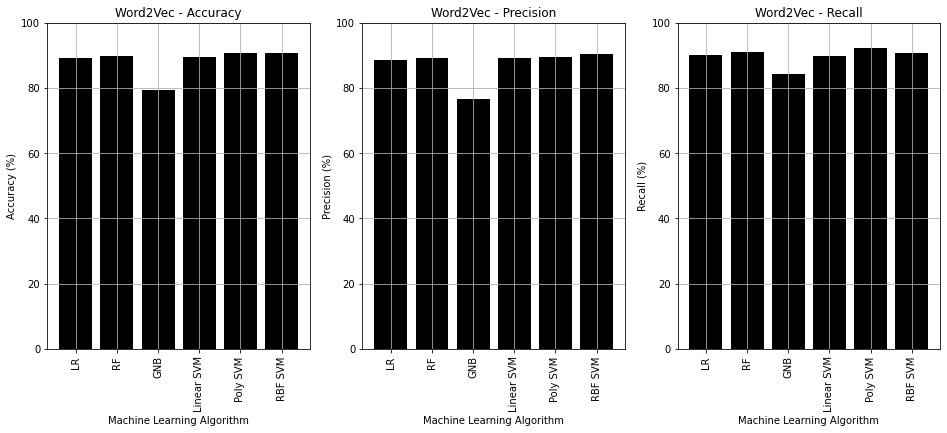

In [17]:
plt.figure(figsize=(16, 6))

#plot 1:

plt.subplot(1, 3, 1)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_accuracy_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Accuracy (%)')
plt.title('Word2Vec - Accuracy')

#plot 2:

plt.subplot(1, 3, 2)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_precision_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Precision (%)')
plt.title('Word2Vec - Precision')

#plot 3:

plt.subplot(1, 3, 3)
plt.gca().set_ylim([0,100])
plt.bar(graph_x_names, graph_recall_data, color=['black'])
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Machine Learning Algorithm')
plt.ylabel('Recall (%)')
plt.title('Word2Vec - Recall')